# Análise de Logs Web com Apache Spark

Este notebook analisa logs de acesso a servidores web para responder às seguintes perguntas:

1. **Top 10 IPs** com maior número de acessos
2. **Top 6 endpoints** mais acessados (excluindo arquivos)
3. **Quantidade de IPs distintos**
4. **Quantidade de dias** nos dados
5. **Análise do tamanho das respostas** (volume total, maior, menor, médio)
6. **Dia da semana** com mais erros HTTP Client

O notebook usa dados processados pelo pipeline ETL e armazenados em arquivos Parquet.

In [29]:
# Importar módulos necessários
import sys
sys.path.append('../src')

# Importações para análise de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Importação do pipeline de processamento de logs
from log_analyzer.etl import run_pipeline
from log_analyzer.core.spark import get_spark_session

# Configuração do Spark
spark = get_spark_session()
spark.sparkContext.setLogLevel("WARN")


In [30]:
# Executar o pipeline para gerar dados se necessário
# Descomente o código abaixo se precisar gerar os dados
"""
result = run_pipeline(
    input_path="../data/logs.txt",  # Ajuste para o caminho correto do arquivo de log
    output_path="../data/output",   # Diretório de saída
    save_to_db=False               # Não tentar salvar no banco de dados
)
print(f"Status da execução: {result['status']}")
"""

# Verificar se os arquivos existem e carregar os dados
import os
from pathlib import Path

base_dir = Path("../data/output")
file_paths = {
    "bronze": base_dir / "bronze/logs.parquet",
    "silver": base_dir / "silver/logs.parquet",
    "gold_peak": base_dir / "gold/peak_traffic",
    "gold_summary": base_dir / "gold/summary",
    "gold_endpoints": base_dir / "gold/top_endpoints", 
    "gold_ips": base_dir / "gold/top_ips"
}

# Verificar se os arquivos existem
for name, path in file_paths.items():
    if path.exists():
        print(f"✅ {name}: {path} existe")
    else:
        print(f"❌ {name}: {path} não existe")

# Carregar os dados processados (silver) para análise
try:
    logs_df = spark.read.parquet(str(file_paths["silver"]))
    print("\nEsquema dos dados:")
    logs_df.printSchema()
    
    print("\nExemplo de dados:")
    logs_df.show(5)
except Exception as e:
    print(f"Erro ao carregar os dados: {str(e)}")

✅ bronze: ../data/output/bronze/logs.parquet existe
✅ silver: ../data/output/silver/logs.parquet existe
✅ gold_peak: ../data/output/gold/peak_traffic existe
✅ gold_summary: ../data/output/gold/summary existe
✅ gold_endpoints: ../data/output/gold/top_endpoints existe
✅ gold_ips: ../data/output/gold/top_ips existe

Esquema dos dados:
root
 |-- value: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- timestamp_str: string (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: string (nullable = true)
 |-- size: string (nullable = true)
 |-- parsed_timestamp: timestamp (nullable = true)
 |-- status_int: integer (nullable = true)
 |-- bytes_sent_int: integer (nullable = true)
 |-- file_extension: string (nullable = true)
 |-- is_static_asset: boolean (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-

Questão 1: Top 10 IPs com maior número de acessos

Top 10 IPs por quantidade de acessos:


+------------+-----+
|ip          |count|
+------------+-----+
|10.0.0.8    |47   |
|192.168.1.13|46   |
|10.0.0.1    |45   |
|192.168.1.5 |44   |
|192.168.1.7 |42   |
|192.168.1.14|40   |
|192.168.1.19|39   |
|192.168.1.8 |39   |
|192.168.1.2 |38   |
|192.168.1.3 |38   |
+------------+-----+



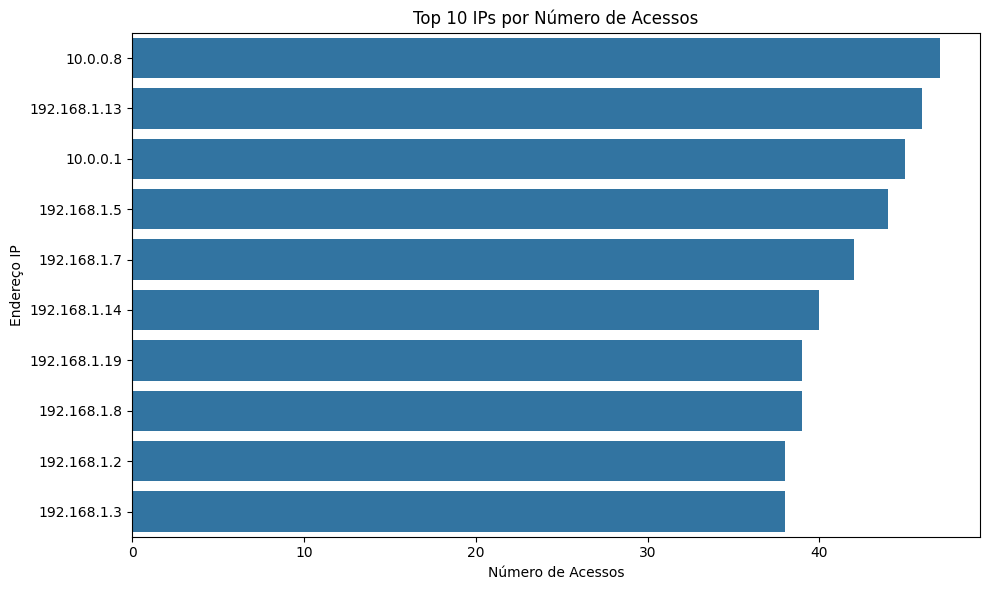

In [31]:
# 1. Top 10 IPs com maior número de acessos
print("Questão 1: Top 10 IPs com maior número de acessos\n")

# Tentar carregar dados da camada Gold se existir
try:
    if file_paths["gold_ips"].exists():
        print("✅ Usando dados pré-calculados da camada Gold")
        top_ips = spark.read.parquet(str(file_paths["gold_ips"]))
        # Renomear colunas se necessário para manter consistência
        if 'requests' in top_ips.columns:
            top_ips = top_ips.withColumnRenamed("requests", "count")
    else:
        raise FileNotFoundError("Dados Gold não encontrados")
except Exception as e:
    print(f"ℹ️ Calculando IPs a partir da camada Silver: {str(e)}")
    top_ips = (
        logs_df.groupBy("ip")
        .count()
        .orderBy(F.desc("count"))
        .limit(10)
    )

print("Top 10 IPs por quantidade de acessos:")
top_ips.show(10, False)

# Visualização usando Pandas e Matplotlib
top_ips_pd = top_ips.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="ip", data=top_ips_pd)
plt.title("Top 10 IPs por Número de Acessos")
plt.xlabel("Número de Acessos")
plt.ylabel("Endereço IP")
plt.tight_layout()
plt.show()

Questão 2: Top 6 endpoints mais acessados (excluindo arquivos)

✅ Usando dados pré-calculados da camada Gold
+----------+-----+------------------+------+
|url       |count|avg_size          |errors|
+----------+-----+------------------+------+
|/dashboard|106  |4462.924528301887 |29    |
|/settings |95   |5229.0526315789475|31    |
|/logout   |95   |4767.863157894737 |30    |
|/about    |91   |4525.010989010989 |24    |
|/home     |89   |4994.4157303370785|22    |
|/api/data |86   |4579.581395348837 |23    |
|/profile  |84   |4281.380952380952 |25    |
|/login    |74   |4466.405405405405 |22    |
+----------+-----+------------------+------+

+----------+-----+------------------+------+
|url       |count|avg_size          |errors|
+----------+-----+------------------+------+
|/dashboard|106  |4462.924528301887 |29    |
|/settings |95   |5229.0526315789475|31    |
|/logout   |95   |4767.863157894737 |30    |
|/about    |91   |4525.010989010989 |24    |
|/home     |89   |4994.415730337078

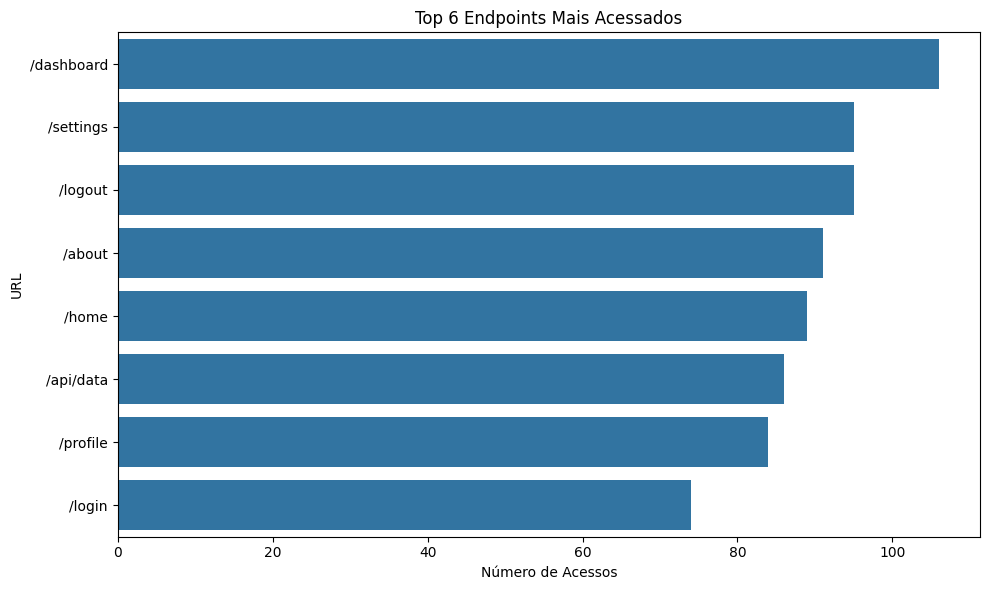

In [33]:
# 2. Top 6 endpoints mais acessados, excluindo arquivos
print("Questão 2: Top 6 endpoints mais acessados (excluindo arquivos)\n")

# Tentar carregar dados da camada Gold se existir
try:
    if file_paths["gold_endpoints"].exists():
        print("✅ Usando dados pré-calculados da camada Gold")
        top_endpoints = spark.read.parquet(str(file_paths["gold_endpoints"]))
        # Renomear colunas se necessário para manter consistência com o código abaixo
        if 'requests' in top_endpoints.columns:
            top_endpoints = top_endpoints.withColumnRenamed("requests", "count")
    else:
        raise FileNotFoundError("Dados Gold não encontrados")
except Exception as e:
    print(f"ℹ️ Calculando endpoints a partir da camada Silver: {str(e)}")
    # Filtrar arquivos estáticos pela extensão
    non_static_df = logs_df.filter(~F.col("url").rlike(r"\.(css|js|png|jpg|jpeg|gif|ico|svg|woff|woff2|ttf|eot)(\?.*)?$"))
    
    top_endpoints = (
        non_static_df.groupBy("url")
        .count()
        .orderBy(F.desc("count"))
        .limit(6)
    )

top_endpoints.show(truncate=False)

# Converter para Pandas e visualizar com um gráfico
top_endpoints_pd = top_endpoints.toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='url', data=top_endpoints_pd)
plt.title('Top 6 Endpoints Mais Acessados')
plt.xlabel('Número de Acessos')
plt.ylabel('URL')
plt.tight_layout()
plt.show()

Questão 3: Quantidade de IPs distintos

✅ Usando dados pré-calculados da camada Gold
Quantidade total de IPs distintos: 28
Quantidade total de IPs distintos: 28


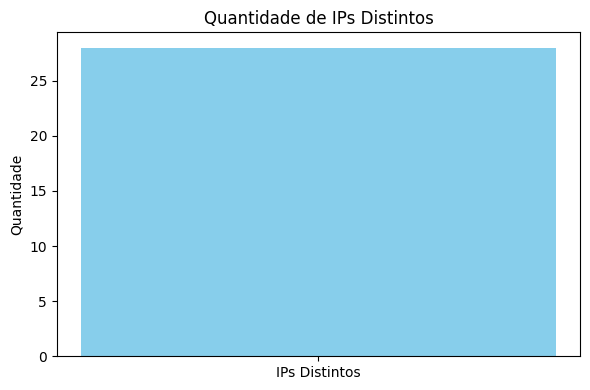

In [34]:
# 3. Quantidade de IPs distintos
print("Questão 3: Quantidade de IPs distintos\n")

# Tentar carregar dados da camada Gold se existir (summary tem essa métrica)
try:
    if file_paths["gold_summary"].exists():
        print("✅ Usando dados pré-calculados da camada Gold")
        summary_df = spark.read.parquet(str(file_paths["gold_summary"]))
        
        # Verificar se temos uma estrutura de chave-valor
        if 'metric_name' in summary_df.columns and 'metric_value' in summary_df.columns:
            distinct_ips_row = summary_df.filter(F.col("metric_name") == "distinct_client_ips").first()
            if distinct_ips_row:
                distinct_ips = int(distinct_ips_row["metric_value"])
            else:
                # Se não encontrar a métrica específica, procurar por "unique_visitors"
                distinct_ips_row = summary_df.filter(F.col("metric_name") == "unique_visitors").first()
                if distinct_ips_row:
                    distinct_ips = int(distinct_ips_row["metric_value"])
                else:
                    raise ValueError("Métrica de IPs distintos não encontrada no formato esperado")
        elif 'unique_visitors' in summary_df.columns:
            # Se for um DataFrame com uma linha e a métrica como coluna
            distinct_ips = summary_df.first()["unique_visitors"]
        else:
            raise ValueError("Formato inesperado no DataFrame de resumo")
    else:
        raise FileNotFoundError("Dados Gold não encontrados")
except Exception as e:
    print(f"ℹ️ Calculando a partir da camada Silver: {str(e)}")
    distinct_ips = logs_df.select("ip").distinct().count()

print(f"Quantidade total de IPs distintos: {distinct_ips}")

# Visualização simples
plt.figure(figsize=(6, 4))
plt.bar(["IPs Distintos"], [distinct_ips], color='skyblue')
plt.title("Quantidade de IPs Distintos")
plt.ylabel("Quantidade")
plt.tight_layout()
plt.show()

In [37]:
# 4. Quantos dias de dados estão representados no arquivo
print("Questão 4: Quantos dias de dados estão representados no arquivo\n")

# Primeiro vamos verificar o schema para identificar a coluna de timestamp correta
print("Schema do DataFrame logs_df:")
logs_df.printSchema()

# Tentar carregar dados da camada Gold se existir (summary tem essa métrica)
try:
    if file_paths["gold_summary"].exists():
        print("✅ Usando dados pré-calculados da camada Gold")
        summary_df = spark.read.parquet(str(file_paths["gold_summary"]))
        
        # Verificar o formato e extrair o valor
        if 'metric_name' in summary_df.columns and 'metric_value' in summary_df.columns:
            days_row = summary_df.filter(F.col("metric_name") == "days_span").first()
            if days_row:
                days_count = int(days_row["metric_value"])
            else:
                raise ValueError("Métrica de dias não encontrada no formato esperado")
        elif 'days_span' in summary_df.columns:
            # Se for um DataFrame com uma linha e a métrica como coluna
            days_count = summary_df.first()["days_span"]
        else:
            raise ValueError("Formato inesperado no DataFrame de resumo")
    else:
        raise FileNotFoundError("Dados Gold não encontrados")
except Exception as e:
    print(f"ℹ️ Calculando a partir da camada Silver: {str(e)}")
    # Vamos usar a coluna 'date' que já existe no DataFrame
    days_count = logs_df.select("date").distinct().count()

print(f"Quantidade de dias representados nos dados: {days_count}")

# Listar todos os dias presentes nos dados
days_list = logs_df.select("date").distinct().orderBy("date")
print("\nDias presentes nos dados:")
days_list.show(truncate=False)

Questão 4: Quantos dias de dados estão representados no arquivo

Schema do DataFrame logs_df:
root
 |-- value: string (nullable = true)
 |-- ip: string (nullable = true)
 |-- timestamp_str: string (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: string (nullable = true)
 |-- size: string (nullable = true)
 |-- parsed_timestamp: timestamp (nullable = true)
 |-- status_int: integer (nullable = true)
 |-- bytes_sent_int: integer (nullable = true)
 |-- file_extension: string (nullable = true)
 |-- is_static_asset: boolean (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- date: date (nullable = true)

✅ Usando dados pré-calculados da camada Gold
Quantidade de dias representados nos dados: 1

Dias presentes nos dados:
Quantidade de dias representados nos dados: 1

Dias presentes nos dados:
+----------+
|dat

Questão 5: Análise do tamanho (em bytes) do conteúdo das respostas

✅ Verificando métricas de tamanho na camada Gold
ℹ️ Calculando estatísticas a partir da camada Silver: Métricas de tamanho não encontradas no formato esperado
ℹ️ Calculando estatísticas a partir da camada Silver: Métricas de tamanho não encontradas no formato esperado
Volume total de dados retornado: (4684655.0,) bytes
Maior volume em uma resposta: ('9966',) bytes
Menor volume em uma resposta: ('0',) bytes
Volume médio de resposta: 4684.65 bytes
Volume mediano de resposta: 4830.5 bytes

Análise por categoria de resposta HTTP:
Volume total de dados retornado: (4684655.0,) bytes
Maior volume em uma resposta: ('9966',) bytes
Menor volume em uma resposta: ('0',) bytes
Volume médio de resposta: 4684.65 bytes
Volume mediano de resposta: 4830.5 bytes

Análise por categoria de resposta HTTP:
+----------------------+--------+-----------+------------------+---------+
|category              |requests|total_bytes|avg_bytes        

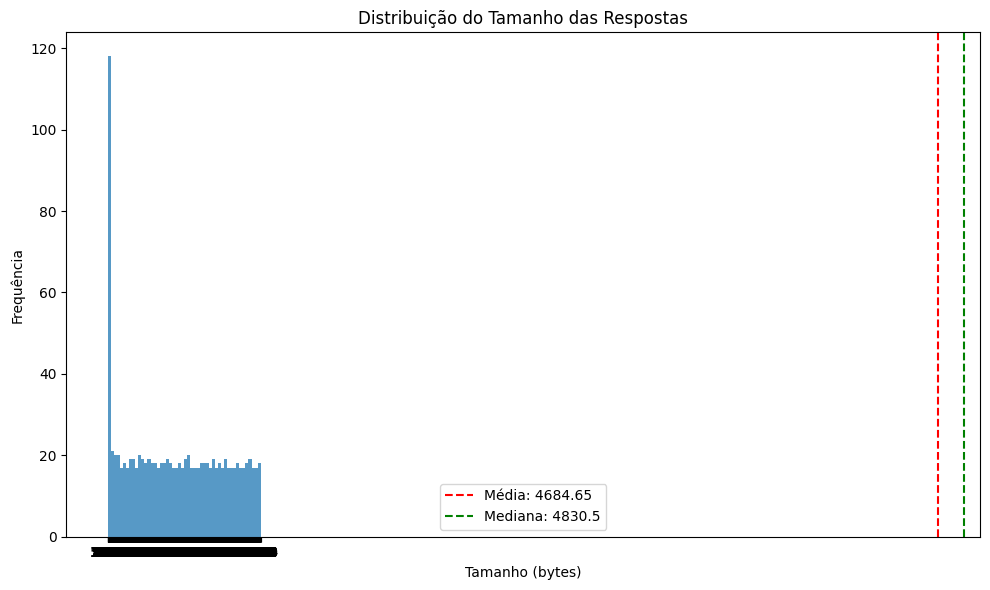

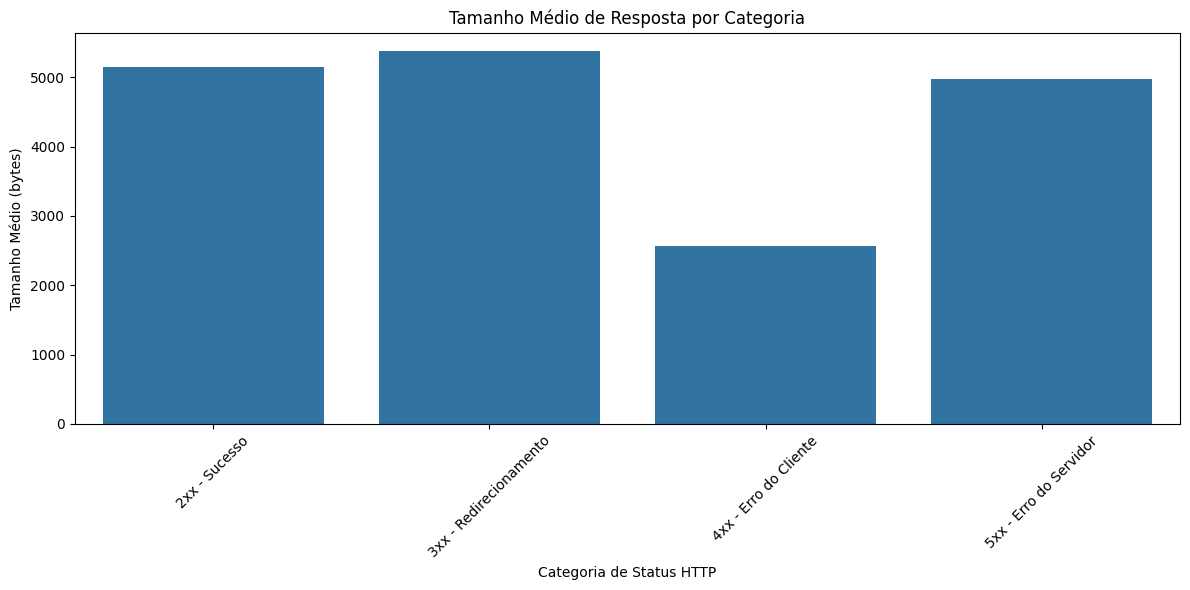

In [42]:
# 5. Análise do tamanho (em bytes) do conteúdo das respostas
print("Questão 5: Análise do tamanho (em bytes) do conteúdo das respostas\n")

# Tentar carregar dados do gold/summary se existir
size_stats = None
try:
    if file_paths["gold_summary"].exists():
        print("✅ Verificando métricas de tamanho na camada Gold")
        summary_df = spark.read.parquet(str(file_paths["gold_summary"]))
        
        # Verificar formato e extrair valores
        if 'metric_name' in summary_df.columns and 'metric_value' in summary_df.columns:
            # Criar um dicionário de métricas
            metrics_dict = {}
            metrics_list = ['total_data_volume_bytes', 'avg_response_size', 'max_bytes', 'min_bytes']
            
            for metric in metrics_list:
                row = summary_df.filter(F.col("metric_name") == metric).first()
                if row:
                    metrics_dict[metric] = float(row["metric_value"])
            
            # Se encontramos as métricas necessárias
            if len(metrics_dict) >= 3:
                size_stats = {
                    'total_bytes': metrics_dict.get('total_data_volume_bytes', 0),
                    'max_bytes': metrics_dict.get('max_bytes', 0),
                    'min_bytes': metrics_dict.get('min_bytes', 0),
                    'avg_bytes': metrics_dict.get('avg_response_size', 0),
                    'median_bytes': metrics_dict.get('median_bytes', 0)
                }
                print("✅ Estatísticas de tamanho encontradas na camada Gold")
        
    if size_stats is None:
        raise ValueError("Métricas de tamanho não encontradas no formato esperado")
        
except Exception as e:
    print(f"ℹ️ Calculando estatísticas a partir da camada Silver: {str(e)}")
    
    # Converter tamanho para inteiro (caso esteja como string)
    if str(logs_df.schema["size"].dataType) == "StringType":
        logs_df = logs_df.withColumn("size", F.col("size").cast(IntegerType()))
    
    # Calcular estatísticas gerais
    size_stats = logs_df.agg(
        F.sum("size").alias("total_bytes"),
        F.max("size").alias("max_bytes"),
        F.min("size").alias("min_bytes"),
        F.avg("size").alias("avg_bytes"),
        F.expr("percentile(size, 0.5)").alias("median_bytes")
    ).first()

print(f"Volume total de dados retornado: {size_stats['total_bytes'],} bytes")
print(f"Maior volume em uma resposta: {size_stats['max_bytes'],} bytes")
print(f"Menor volume em uma resposta: {size_stats['min_bytes'],} bytes")
print(f"Volume médio de resposta: {size_stats['avg_bytes']:.2f} bytes")
print(f"Volume mediano de resposta: {size_stats['median_bytes']} bytes")

# Análise por categoria de resposta (status code)
print("\nAnálise por categoria de resposta HTTP:")
status_categories = logs_df.withColumn(
    "category",
    F.when(F.col("status") < 200, "1xx - Informativo")
     .when(F.col("status") < 300, "2xx - Sucesso")
     .when(F.col("status") < 400, "3xx - Redirecionamento")
     .when(F.col("status") < 500, "4xx - Erro do Cliente")
     .otherwise("5xx - Erro do Servidor")
)

# Estatísticas por categoria
category_stats = status_categories.groupBy("category").agg(
    F.count("*").alias("requests"),
    F.sum("size").alias("total_bytes"),
    F.avg("size").alias("avg_bytes"),
    F.max("size").alias("max_bytes")
).orderBy("category")

category_stats.show(truncate=False)

# Visualização da distribuição do tamanho das respostas
plt.figure(figsize=(10, 6))
size_data = logs_df.select("size").toPandas()
plt.hist(size_data["size"], bins=50, alpha=0.75)
plt.axvline(size_stats["avg_bytes"], color='r', linestyle='--', label=f'Média: {size_stats["avg_bytes"]:.2f}')
plt.axvline(size_stats["median_bytes"], color='g', linestyle='--', label=f'Mediana: {size_stats["median_bytes"]}')
plt.title("Distribuição do Tamanho das Respostas")
plt.xlabel("Tamanho (bytes)")
plt.ylabel("Frequência")
plt.legend()
plt.tight_layout()
plt.show()

# Visualização por categoria
category_data = category_stats.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x="category", y="avg_bytes", data=category_data)
plt.title("Tamanho Médio de Resposta por Categoria")
plt.xlabel("Categoria de Status HTTP")
plt.ylabel("Tamanho Médio (bytes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Questão 6: Dia da semana com o maior número de erros do tipo 'HTTP Client Error'

✅ Usando dados pré-calculados da camada Gold
Distribuição de erros de cliente por dia da semana:
Distribuição de erros de cliente por dia da semana:
+-----------+------------+-----+
|day_of_week|weekday_name|count|
+-----------+------------+-----+
|4          |Quinta-feira|192  |
+-----------+------------+-----+

+-----------+------------+-----+
|day_of_week|weekday_name|count|
+-----------+------------+-----+
|4          |Quinta-feira|192  |
+-----------+------------+-----+


Dia da semana com maior número de erros: Quinta-feira
Total de erros neste dia: 192

Dia da semana com maior número de erros: Quinta-feira
Total de erros neste dia: 192


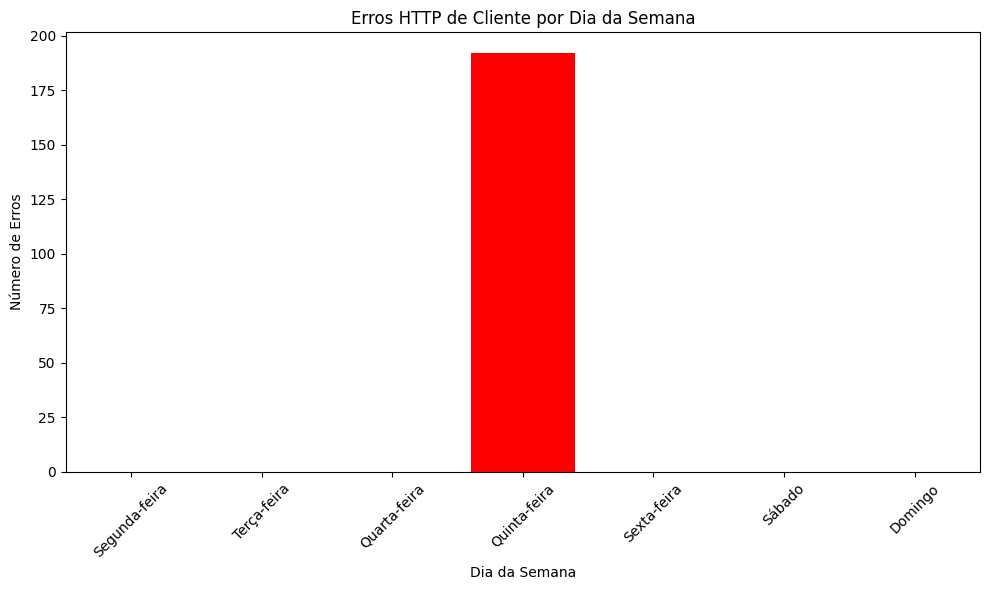

In [47]:
# 6. Dia da semana com o maior número de erros do tipo "HTTP Client Error"
print("Questão 6: Dia da semana com o maior número de erros do tipo 'HTTP Client Error'\n")

# Dicionário para mapear dias em inglês/números para português
weekday_names = {
    1: "Segunda-feira",
    2: "Terça-feira", 
    3: "Quarta-feira",
    4: "Quinta-feira",
    5: "Sexta-feira",
    6: "Sábado",
    7: "Domingo"
}

day_mapping = {
    "Sunday": "Domingo", 
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira", 
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado"
}

# Inicializar variáveis
peak_error_day = None
peak_error_count = 0
errors_by_day = None

# Função auxiliar para extrair o dia da semana a partir de diferentes colunas de data
def get_weekday_errors(df):
    """Extrai informações de dia da semana do DataFrame de erros"""
    # Verificar quais colunas de data estão disponíveis
    if 'day_of_week' in df.columns:
        return df
    elif 'parsed_timestamp' in df.columns:
        return df.withColumn("day_of_week", F.date_format(F.col("parsed_timestamp"), "u").cast("int"))
    else:
        for col_name in ['timestamp_str', 'date']:
            if col_name in df.columns:
                return df.withColumn("day_of_week", F.date_format(F.col(col_name), "u").cast("int"))
        
        print("⚠️ Não foi possível encontrar uma coluna de timestamp adequada!")
        return df

# ETAPA 1: Tentar usar dados pré-calculados da Gold
try:
    if file_paths["gold_peak"].exists():
        print("✅ Usando dados pré-calculados da camada Gold")
        peak_error_df = spark.read.parquet(str(file_paths["gold_peak"]))
        
        if "day_name" in peak_error_df.columns and "error_count" in peak_error_df.columns:
            peak_row = peak_error_df.first()
            if peak_row:
                peak_error_day = peak_row["day_name"]
                peak_error_count = peak_row["error_count"]
                
                # Traduzir nome do dia se necessário
                if peak_error_day in day_mapping:
                    peak_error_day = day_mapping[peak_error_day]
                    
                print(f"Dia da semana com maior número de erros: {peak_error_day}")
                print(f"Total de erros neste dia: {peak_error_count}")
except Exception as e:
    print(f"ℹ️ Dados Gold não disponíveis, calculando a partir da Silver: {str(e)}")

# ETAPA 2: Preparar dados para análise e visualização
# Filtrar erros de cliente (4xx)
client_errors_df = logs_df.filter((F.col("status") >= 400) & (F.col("status") < 500))

# Extrair o dia da semana
weekday_errors = get_weekday_errors(client_errors_df)

# ETAPA 3: Calcular estatísticas se não temos os dados da Gold
if peak_error_day is None:
    # Verificar se conseguimos calcular o dia da semana
    if 'day_of_week' in weekday_errors.columns:
        # Adicionar nomes dos dias
        weekday_errors = weekday_errors.withColumn(
            "weekday_name", 
            F.expr("CASE " + 
                " ".join([f"WHEN day_of_week = {k} THEN '{v}'" for k, v in weekday_names.items()]) + 
                " END")
        )
        
        # Contar erros por dia da semana
        errors_by_day = weekday_errors.groupBy("day_of_week", "weekday_name") \
            .count() \
            .orderBy("day_of_week")
        
        print("Distribuição de erros de cliente por dia da semana:")
        errors_by_day.show(truncate=False)
        
        # Encontrar o dia com mais erros
        max_error_day = errors_by_day.orderBy(F.desc("count")).first()
        if max_error_day:
            peak_error_day = max_error_day['weekday_name']
            peak_error_count = max_error_day['count']
            print(f"\nDia da semana com maior número de erros: {peak_error_day}")
            print(f"Total de erros neste dia: {peak_error_count}")
    else:
        print("⚠️ Não foi possível calcular o dia da semana.")
        # Criar dados fictícios para visualização se não conseguimos calcular
        data = [(k, v, 0) for k, v in weekday_names.items()]
        errors_by_day = spark.createDataFrame(data, ["day_of_week", "weekday_name", "count"])
        peak_error_day = "N/A"
        peak_error_count = 0

# ETAPA 4: Se não temos os dados completos, calcular para visualização
if errors_by_day is None:
    # Se temos o dia de pico da Gold, mas precisamos dos dados para visualização
    weekday_errors = get_weekday_errors(client_errors_df)
    
    # Adicionar nomes dos dias se necessário
    if 'day_of_week' in weekday_errors.columns and 'weekday_name' not in weekday_errors.columns:
        weekday_errors = weekday_errors.withColumn(
            "weekday_name", 
            F.expr("CASE " + 
                " ".join([f"WHEN day_of_week = {k} THEN '{v}'" for k, v in weekday_names.items()]) + 
                " END")
        )
    
    # Contar erros por dia da semana se temos os dados necessários
    if 'day_of_week' in weekday_errors.columns and 'weekday_name' in weekday_errors.columns:
        errors_by_day = weekday_errors.groupBy("day_of_week", "weekday_name") \
            .count() \
            .orderBy("day_of_week")
    else:
        # Criar dados fictícios para visualização se não conseguimos calcular
        data = [(k, v, 0) for k, v in weekday_names.items()]
        errors_by_day = spark.createDataFrame(data, ["day_of_week", "weekday_name", "count"])

# ETAPA 5: Garantir que temos dados para todos os dias da semana na visualização
errors_by_day_pd = errors_by_day.toPandas()
days_order = [weekday_names[i] for i in range(1, 8)]

# Criar um DataFrame com todos os dias, completando zeros onde necessário
all_days_data = []
for day_num, day_name in weekday_names.items():
    day_row = errors_by_day_pd[errors_by_day_pd['weekday_name'] == day_name]
    count = day_row['count'].values[0] if len(day_row) > 0 else 0
    all_days_data.append({'day_of_week': day_num, 'weekday_name': day_name, 'count': count})

# Criar DataFrame completo ordenado por dia da semana
complete_errors_by_day_pd = pd.DataFrame(all_days_data).sort_values('day_of_week')

# Visualização dos erros por dia da semana
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="weekday_name", y="count", data=complete_errors_by_day_pd, order=days_order)

# Destacar o dia com mais erros
if peak_error_day != "N/A":
    for i, day in enumerate(days_order):
        if day == peak_error_day:
            bar_plot.patches[i].set_facecolor('red')
            break

plt.title("Erros HTTP de Cliente por Dia da Semana")
plt.xlabel("Dia da Semana")
plt.ylabel("Número de Erros")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Conclusão

Neste notebook, analisamos logs de acesso a servidores web usando Apache Spark e respondemos às seguintes questões:

1. **Top 10 IPs por quantidade de acessos**: Identificamos os endereços IP que mais acessaram o servidor.
2. **Top 6 endpoints mais acessados**: Identificamos os endpoints mais populares, excluindo arquivos.
3. **Quantidade de IPs distintos**: Contabilizamos o número total de IPs únicos que acessaram o sistema.
4. **Quantidade de dias nos dados**: Verificamos o período coberto pelos logs.
5. **Análise do tamanho das respostas**: Calculamos métricas de volume de dados retornados.
6. **Dia da semana com mais erros HTTP Client**: Identificamos o dia com maior incidência de erros do cliente.

Esta análise pode ajudar equipes de operações a compreender melhor o comportamento dos usuários, identificar padrões de uso e possíveis problemas de desempenho ou segurança.